In [1]:
import pandas as pd
import scipy
import numpy as np
from scipy import spatial
from scipy import sparse as sp
import time
import matplotlib.pyplot as plt
import tqdm
import implicit
from datasets import load_dataset

/home/armkilikia/Documents/Babken/Sber/item_rec/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
interactions = pd.read_csv('interactions.csv')
# item_asset = pd.read_csv('item_asset.csv')
# item_price = pd.read_csv('item_price.csv')
# item_subclass = pd.read_csv('item_subclass.csv')
# user_age = pd.read_csv('user_age.csv')
# user_region = pd.read_csv('user_region.csv')

In [4]:
interactions.head()

,row,col,data
0,0,3568,1.0
1,0,3827,1.0
2,0,4844,1.0
3,0,5734,1.0
4,0,6518,1.0


In [5]:
len(interactions.row.unique())

27255

In [6]:
len(interactions.col.unique())

15277

(array([46667., 42140., 43087., 46597., 48976., 42361., 38040., 31214.,
        33250., 26304.]),
 array([    0.,  3091.,  6182.,  9273., 12364., 15455., 18546., 21637.,
        24728., 27819., 30910.]),
 <BarContainer object of 10 artists>)

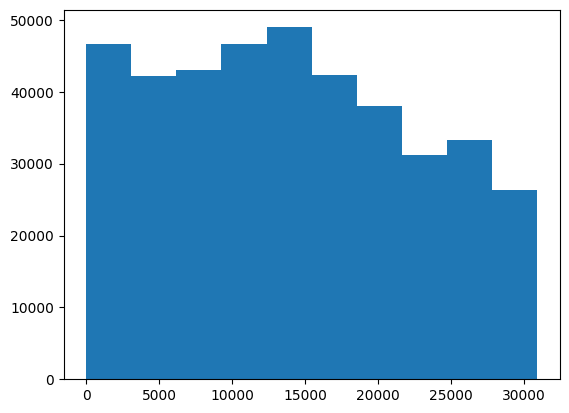

In [7]:
plt.hist(interactions.row)

(array([26996., 28730., 92234., 59779., 60308., 32856., 21886., 18391.,
        30246., 27210.]),
 array([    0. ,  1849.4,  3698.8,  5548.2,  7397.6,  9247. , 11096.4,
        12945.8, 14795.2, 16644.6, 18494. ]),
 <BarContainer object of 10 artists>)

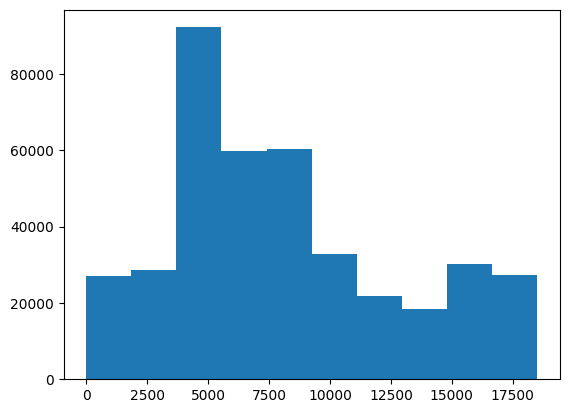

In [8]:
plt.hist(interactions.col)

In [9]:
set_of_users = interactions.row.unique()
set_of_items = interactions.col.unique()

sorted_set_of_items = sorted(set_of_items)
sorted_set_of_users = sorted(set_of_items)

In [10]:
raw_to_usr = {raw : usr for raw, usr in enumerate(sorted_set_of_users)}
col_to_item = {col : usr for col, usr in enumerate(sorted_set_of_items)}

In [11]:
new_inter = pd.pivot_table(interactions, index = 'row', columns = 'col', values= 'data').fillna(0)

In [12]:
new_inter

col,0,2,4,5,6,7,9,10,11,12,...,18485,18486,18487,18488,18489,18490,18491,18492,18493,18494
row,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30905,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
new_sp = sp.csr_matrix(new_inter)

In [14]:
train_dataset = new_sp.toarray()

In [16]:
train_usr_item = {}
test_usr_item = {}
for user in range(train_dataset.shape[0]):
  user_items = np.where(train_dataset[user] == 1.)[0]
  if len(user_items) == 1:
    train_usr_item[user] = []
    test_usr_item[user] = user_items
  else:
    num_of_items = len(user_items)
    train_usr_item[user] = np.random.choice(user_items, int(0.8 * num_of_items), replace = False)
    test_usr_item[user] = np.setdiff1d(user_items, train_usr_item[user])

    train_dataset[user][test_usr_item[user]] = 0.

In [31]:
np.mean([1, 2, 3, 4, 5])

3.0

In [19]:
train_usr_item[3]

[]

In [20]:
train_dataset = sp.csr_matrix(train_dataset)

In [21]:
# Building the model
model = implicit.als.AlternatingLeastSquares(factors=80, regularization=0.01, iterations=10) #50)

model.fit(train_dataset)

/usr/local/lib/python3.10/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/10 [00:00<?, ?it/s]

In [22]:
train_usr_item[3]

[]

In [23]:
test_usr_item[3]

array([3185])

In [24]:
model.recommend(3, train_dataset[3])

(array([ 5917,  4601,  8075,  4237,  6058,  5056, 14846,  7575,  7585,
         6813], dtype=int32),
 array([0.00827079, 0.00730994, 0.00612491, 0.00596899, 0.00480986,
        0.00458902, 0.00439101, 0.00396821, 0.00381185, 0.00360621],
       dtype=float32))

In [27]:
predictions = [[] for i in range(train_dataset.shape[0])]

for user in range(train_dataset.shape[0]):
  predictions[user] = model.recommend(user, train_dataset[user], filter_already_liked_items = True)[0]

In [30]:
predictions[4]

array([3874, 3861, 5056, 3855, 6692, 3901, 5947, 3055, 3865, 4573],
      dtype=int32)

In [32]:
predictions[3]

array([ 5917,  4601,  8075,  4237,  6058,  5056, 14846,  7575,  7585,
        6813], dtype=int32)

In [34]:
len(predictions)

27255

In [25]:
intersection = []
for user in range(train_dataset.shape[0]):
  inter = set(test_usr_item[user]).intersection(set(
      model.recommend(user, train_dataset[user], filter_already_liked_items = True)[0]
      ))
  if len(inter) > 0:
    intersection.append((user, inter))

In [2]:
data_files = {"interactions" : "interactions.csv", 
              "item_price" : "item_price.csv",
              "item_asset" : "item_asset.csv",
              "item_subclass" : "item_subclass.csv",
              "user_age" : "user_age.csv",
              "user_region" : "user_region.csv"}
dataset = load_dataset('KenBars/item_rec', data_files=data_files, data_dir='data')

In [5]:
for file_name in data_files:
    dataset[file_name].to_csv(f'notebooks/data/{file_name}.csv') # type: ignore

Creating CSV from Arrow format: 100%|██████████| 27/27 [00:00<00:00, 120.82ba/s]


In [7]:
dataset = load_dataset("KenBars/item_rec", "default")

FileNotFoundError: Couldn't find a dataset script at /home/armkilikia/Documents/Babken/Sber/item_rec/KenBars/item_rec/item_rec.py or any data file in the same directory. Couldn't find 'KenBars/item_rec' on the Hugging Face Hub either: FileNotFoundError: Unable to find 'hf://datasets/KenBars/item_rec@aae18f7c186b5d33fd339c0d0784fa9b1cdc236e/interactions.csv' with any supported extension ['.csv', '.tsv', '.json', '.jsonl', '.parquet', '.arrow', '.txt', '.blp', '.bmp', '.dib', '.bufr', '.cur', '.pcx', '.dcx', '.dds', '.ps', '.eps', '.fit', '.fits', '.fli', '.flc', '.ftc', '.ftu', '.gbr', '.gif', '.grib', '.h5', '.hdf', '.png', '.apng', '.jp2', '.j2k', '.jpc', '.jpf', '.jpx', '.j2c', '.icns', '.ico', '.im', '.iim', '.tif', '.tiff', '.jfif', '.jpe', '.jpg', '.jpeg', '.mpg', '.mpeg', '.msp', '.pcd', '.pxr', '.pbm', '.pgm', '.ppm', '.pnm', '.psd', '.bw', '.rgb', '.rgba', '.sgi', '.ras', '.tga', '.icb', '.vda', '.vst', '.webp', '.wmf', '.emf', '.xbm', '.xpm', '.BLP', '.BMP', '.DIB', '.BUFR', '.CUR', '.PCX', '.DCX', '.DDS', '.PS', '.EPS', '.FIT', '.FITS', '.FLI', '.FLC', '.FTC', '.FTU', '.GBR', '.GIF', '.GRIB', '.H5', '.HDF', '.PNG', '.APNG', '.JP2', '.J2K', '.JPC', '.JPF', '.JPX', '.J2C', '.ICNS', '.ICO', '.IM', '.IIM', '.TIF', '.TIFF', '.JFIF', '.JPE', '.JPG', '.JPEG', '.MPG', '.MPEG', '.MSP', '.PCD', '.PXR', '.PBM', '.PGM', '.PPM', '.PNM', '.PSD', '.BW', '.RGB', '.RGBA', '.SGI', '.RAS', '.TGA', '.ICB', '.VDA', '.VST', '.WEBP', '.WMF', '.EMF', '.XBM', '.XPM', '.aiff', '.au', '.avr', '.caf', '.flac', '.htk', '.svx', '.mat4', '.mat5', '.mpc2k', '.ogg', '.paf', '.pvf', '.raw', '.rf64', '.sd2', '.sds', '.ircam', '.voc', '.w64', '.wav', '.nist', '.wavex', '.wve', '.xi', '.mp3', '.opus', '.AIFF', '.AU', '.AVR', '.CAF', '.FLAC', '.HTK', '.SVX', '.MAT4', '.MAT5', '.MPC2K', '.OGG', '.PAF', '.PVF', '.RAW', '.RF64', '.SD2', '.SDS', '.IRCAM', '.VOC', '.W64', '.WAV', '.NIST', '.WAVEX', '.WVE', '.XI', '.MP3', '.OPUS', '.zip']